In [3]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

#import constants

#from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)
no_controls_df = boda2_df[boda2_df['method'].notnull()].copy().reset_index(drop=True)

NameError: name 'pd' is not defined

In [3]:
train_set_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/MPRA_ALL_no_cutoffs_v2_pred.txt', sep=" ", low_memory=False)

val_test_chrs = ['7', '13', '19', '21', 'X', 'synth']

train_set_df = train_set_df[~train_set_df['chr'].isin(val_test_chrs)].reset_index(drop=True)

In [4]:
row_filter = (train_set_df['data_project'] == 'BODA')
train_set_df.loc[row_filter, 'data_project'] = 'BODA30K'

In [5]:
train_set_df['data_project'].unique()

array(['UKBB', 'GTEX', 'BODA30K'], dtype=object)

In [6]:
boda2_set = set(no_controls_df['sequence'])
train_set = set(train_set_df['nt_sequence'])

common_seqs = list(set.intersection(boda2_set, train_set))

In [7]:
boda2_df[boda2_df['sequence'].isin(common_seqs)]

,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH
100221,control_DHS_H_33811::chr3:171026660-171026860,CTTCTGTCATTGTACTAGTTGGGAGTCCTGTCAATTCCAGGTCTTG...,BODA:DHS_ctrl:hepg2,DHS,0,4.028113,1.742743,1.445707,0.381241,0.224602,0.112135,1000.894016,1000.894016,1000.894016,16331.154092,3349.785396,2726.269341,4.523634,1.429381,1.409159,4.030119,1.714405,1.422210,k562,k562,hepg2,1.742743,k562,4.028113,sknsh,1.445707,2.736910,-0.994167,-2.285371,[-4.20088209e-02 8.55193846e-03 -6.16494101e-...,[-4.89893481e-02 -1.38361333e-03 -3.43579501e-...,[-5.68423234e-02 -4.81187738e-03 -2.63768807e-...
101874,control_DHS_H_18335::chr17:6752150-6752350,TATGATCACCACTGCACTCCAGCCTGAGTGACAGAGACAGACTTCA...,BODA:DHS_ctrl:hepg2,DHS,0,0.157666,3.191531,0.467937,0.219020,0.326134,0.166892,455.302622,455.302622,455.302622,504.678312,4159.488292,629.480840,0.019262,2.673660,0.469135,-0.092915,2.747566,0.588144,hepg2,hepg2,hepg2,3.191531,sknsh,0.467937,k562,0.157666,0.312802,2.878729,2.723594,[ 0.03759375 0.037898984 0.0051485403 ...,[ 0.00963677 0.08172579 -0.013638782 ...,[-1.33113423e-02 5.98120019e-02 -4.65735719e-...
108053,chr17:47219150-47219350,ATTGCCTTATCTGGCCTGGGGGCCGCCTTTCAGCCTGGAACAGGCA...,BODA:genomic,gs,0,5.266974,0.129643,-0.442630,0.262408,0.577703,0.987484,57.917241,57.917241,57.917241,2238.607030,63.410369,42.559150,6.027860,1.338934,0.491005,5.427739,1.343749,0.530178,k562,k562,k562,5.266974,hepg2,0.129643,sknsh,-0.442630,-0.156494,5.423468,5.137331,[ 0.035029884 0.04511998 0.052503977 ...,[ 0.056327116 0.016893879 -0.007978055 0....,[ 0.076467834 0.0148732625 -0.0053850412 0....
108541,chr8:139526450-139526650,CTAATAGTAGGGGTGACATATCTTACATGGAGAGTTGCACCAGACA...,BODA:genomic,gs,0,3.383892,0.122290,-0.862331,0.318232,0.268714,0.234040,627.014177,627.014177,627.014177,6547.372366,682.486373,344.915419,3.221185,-0.299840,-0.562263,2.979186,-0.291803,-0.526748,k562,k562,k562,3.383892,hepg2,0.122290,sknsh,-0.862331,-0.370020,3.753913,3.261602,[-1.54921338e-02 1.02223102e-02 2.08920427e-...,[-0.013326407 -0.015067762 0.017631842 ...,[-0.023244374 -0.009022306 0.0024370165 ...
110405,chr10:4939700-4939900,ACCCAGCTGTCCCTCAGAATGAGTGTGTTCACTGGAGGAGGTGACA...,BODA:genomic,gs,0,-0.201825,2.880101,-0.472145,0.259980,0.372490,0.206225,477.865613,477.865613,477.865613,411.598895,3517.877006,344.458483,-0.092827,4.358390,-0.378521,-0.107952,3.843497,-0.410143,hepg2,hepg2,hepg2,2.880101,k562,-0.201825,sknsh,-0.472145,-0.336985,3.217086,3.081927,[ 0.016578386 -0.00025072493 -0.024031546 ...,[ 4.53420468e-02 -3.82381044e-02 -5.92025928e-...,[ 4.32092398e-02 -1.80174988e-02 -1.77513994e-...
110428,chr6:7241850-7242050,TAACTCACCAGTATCTTTGAGTGAAGAAAGATGTGGGTGCCCACGG...,BODA:genomic,gs,0,0.227298,2.069684,-0.248780,0.168353,0.315163,0.271603,687.639370,687.639370,687.639370,805.177697,2886.592856,578.867168,-0.240401,4.008546,-0.348308,-0.258141,3.306989,-0.349790,hepg2,hepg2,hepg2,2.069684,k562,0.227298,sknsh,-0.248780,-0.010741,2.080425,1.842386,[ 0.07391345 0.028688073 0.056437008 ...,[ 4.61945571e-02 5.34828305e-02 6.23050481e-...,[ 7.80820660e-03 4.39489074e-02 4.42794785e-...
111531,chr3:155138800-155139000,CCTTGGAGTCTGAGTTGGCACTTTCTTCCCTGATGATTCTTTGATA...,BODA:genomic,gs,0,-0.002691,3.050951,-0.162791,0.196618,0.319180,0.201162,511.403200,511.403200,511.403200,509.040325,4237.938510,456.957479,-0.043748,3.711653,-0.392958,-0.039090,3.262296,-0.326767,hepg2,hepg2,hepg2,3.050951,k562,-0.002691,sknsh,-0.162791,-0.082741,3.133692,3.053643,[-3.46017629e-02 -4.93577793e-02 -2.00863015e-...,[-6.69713169e-02 -1.44289032e-01 -1

In [8]:
train_set_df[train_set_df['nt_sequence'].isin(common_seqs)]

,HepG2_mean,HepG2_std,ID_count,IDs,K562_mean,K562_std,OL,OL_count,SKNSH_mean,SKNSH_std,chr,class,ctrl_mean_hepg2,ctrl_mean_k562,ctrl_mean_sknsh,data_project,exp_mean_hepg2,exp_mean_k562,exp_mean_sknsh,lfcSE_hepg2,lfcSE_k562,lfcSE_sknsh,nt_sequence,padj_hepg2,padj_k562,padj_sknsh,pvalue_hepg2,pvalue_k562,pvalue_sknsh,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_rc,HepG2_pred_rc,SKNSH_pred_rc,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg
64261,0.041730,NaN,1,8:140538793:A:G:R:wC,4.291797,NaN,33,1.0,-0.383966,NaN,8,Insomnia,345.625951,345.625951,345.625951,UKBB,356.184724,6780.871792,263.743536,0.190507,0.109390,0.156704,CTAATAGTAGGGGTGACATATCTTACATGGAGAGTTGCACCAGACA...,8.918670e-01,0.000000,2.374215e-02,8.266141e-01,0.000000,1.427502e-02,3.221187,-0.299840,-0.562264,2.737188,-0.283765,-0.491232,2.979187,-0.291803,-0.526748
273590,1.874048,NaN,1,6:7242177:TCAGCCCACTGG:T:R:wC,-0.036447,NaN,31,1.0,-0.252464,NaN,6,HbA1c,634.625779,634.625779,634.625779,UKBB,2326.164324,618.734680,531.343977,0.155298,0.166948,0.275484,TAACTCACCAGTATCTTTGAGTGAAGAAAGATGTGGGTGCCCACGG...,2.818772e-32,0.910889,5.734475e-01,1.570146e-33,0.827182,3.594378e-01,-0.240401,4.008547,-0.348308,-0.275880,2.605433,-0.351272,-0.258141,3.306990,-0.349790
381615,1.292812,NaN,1,17:45296616:A:G:R:wC,5.303366,NaN,42,1.0,-0.153997,NaN,17,GTEx,353.733239,355.223655,353.733239,GTEX,866.038290,14023.367459,317.184510,0.134435,0.110239,0.381529,ATTGCCTTATCTGGCCTGGGGGCCGCCTTTCAGCCTGGAACAGGCA...,3.420675e-21,0.000000,8.164388e-01,6.799790e-22,0.000000,6.864842e-01,6.027863,1.338937,0.491006,4.827616,1.348564,0.569350,5.427739,1.343750,0.530178
399490,3.511782,NaN,1,3:154856689:C:T:R:wC,-0.076727,NaN,42,1.0,-0.680638,NaN,3,GTEx,514.591228,526.279339,514.591228,GTEX,5867.935326,499.292496,321.969392,0.101052,0.216686,0.364690,CCTTGGAGTCTGAGTTGGCACTTTCTTCCCTGATGATTCTTTGATA...,3.102295e-263,0.856147,1.431621e-01,1.286112e-264,0.723269,6.199317e-02,-0.043748,3.711655,-0.392958,-0.034430,2.812943,-0.260576,-0.039089,3.262299,-0.326767
436614,3.693274,NaN,1,10:4981992:G:C:R:wC,-0.453796,NaN,41,1.0,-0.496922,NaN,10,GTEx,449.570870,218.303255,243.237008,GTEX,5811.200165,159.365545,172.430824,0.077852,0.418151,0.272393,ACCCAGCTGTCCCTCAGAATGAGTGTGTTCACTGGAGGAGGTGACA...,0.000000e+00,0.483813,1.209207e-01,0.000000e+00,0.277814,6.810955e-02,-0.092828,4.358390,-0.378522,-0.123078,3.328603,-0.441764,-0.107953,3.843496,-0.410143
658852,1.590484,NaN,1,3:170744549:NA:NA,4.428495,NaN,NaN,NaN,1.204257,NaN,3,DHS_Uniq,421.879338,421.879338,421.879338,BODA30K,1270.306616,9085.195947,972.270659,0.086107,0.105568,0.146590,CTTCTGTCATTGTACTAGTTGGGAGTCCTGTCAATTCCAGGTCTTG...,5.126134e-75,0.000000,1.925630e-15,3.532234e-76,0.000000,2.118866e-16,4.523635,1.429382,1.409159,3.536602,1.999428,1.435258,4.030118,1.714405,1.422209
661896,3.339913,NaN,1,17:6655569:NA:NA,-0.330066,NaN,NaN,NaN,0.316105,NaN,17,DHS_Uniq,206.474827,206.474827,206.474827,BODA30K,2090.571653,164.773022,256.993215,0.167142,0.187765,0.195624,TATGATCACCACTGCACTCCAGCCTGAGTGACAGAGACAGACTTCA...,1.249744e-87,0.132213,1.996549e-01,7.829814e-89,0.078770,1.061206e-01,0.019261,2.673661,0.469135,-0.205091,2.821473,0.707153,-0.092915,2.747567,0.588144
664689,5.412625,NaN,1,8:87268129:NA:NA,-0.114556,NaN,NaN,NaN,0.088441,NaN,8,DHS_Uniq,164.021664,164.021664,164.021664,BODA30K,6986.740562,150.928474,174.398458,0.056344,0.207623,0.221776,AACCTGGGAACTCATTATTTACTTATTTTAATAATTTACAGATTGG...,0.000000e+00,0.675665,7.918215e-01,0.000000e+00,0.581118,6.900515e-01,-0.046622,3.747805,0.216100,-0.175282,4.713953,0.040017,-0.110952,4.230879,0.128059


In [9]:
boda2_df.columns

Index(['ID', 'sequence', 'project', 'method', 'round', 'K562_signal',
       'HepG2_signal', 'SKNSH_signal', 'K562_lfcSE', 'HepG2_lfcSE',
       'SKNSH_lfcSE', 'K562_ctrl_mean', 'HepG2_ctrl_mean', 'SKNSH_ctrl_mean',
       'K562_exp_mean', 'HepG2_exp_mean', 'SKNSH_exp_mean', 'K562_pred',
       'HepG2_pred', 'SKNSH_pred', 'K562_pred_aggreg', 'HepG2_pred_aggreg',
       'SKNSH_pred_aggreg', 'pred_max_cell', 'signal_max_cell', 'target_cell',
       'target_cell_lfc', 'max_non_target_cell', 'max_non_target_lfc',
       'min_non_target_cell', 'min_non_target_lfc', 'mean_non_target_lfc',
       'OverMean', 'OverMax', 'contrib_K562', 'contrib_HepG2',
       'contrib_SKNSH'],
      dtype='object')

In [10]:
train_set_df.columns

Index(['HepG2_mean', 'HepG2_std', 'ID_count', 'IDs', 'K562_mean', 'K562_std',
       'OL', 'OL_count', 'SKNSH_mean', 'SKNSH_std', 'chr', 'class',
       'ctrl_mean_hepg2', 'ctrl_mean_k562', 'ctrl_mean_sknsh', 'data_project',
       'exp_mean_hepg2', 'exp_mean_k562', 'exp_mean_sknsh', 'lfcSE_hepg2',
       'lfcSE_k562', 'lfcSE_sknsh', 'nt_sequence', 'padj_hepg2', 'padj_k562',
       'padj_sknsh', 'pvalue_hepg2', 'pvalue_k562', 'pvalue_sknsh',
       'K562_pred', 'HepG2_pred', 'SKNSH_pred', 'K562_pred_rc',
       'HepG2_pred_rc', 'SKNSH_pred_rc', 'K562_pred_aggreg',
       'HepG2_pred_aggreg', 'SKNSH_pred_aggreg'],
      dtype='object')

In [11]:
train_set_df['project'] = train_set_df.progress_apply(lambda x: x['data_project'] + ':' + x['class'], axis=1)

  0%|          | 0/668946 [00:00<?, ?it/s]

In [12]:
train_set_df['project']

0          UKBB:Depression_GP
1                    UKBB:CAD
2                    UKBB:CAD
3                    UKBB:CAD
4         UKBB:Morning_Person
                 ...         
668941        BODA30K:K27_All
668942       BODA30K:K27_Uniq
668943       BODA30K:K27_Uniq
668944       BODA30K:K27_Uniq
668945       BODA30K:K27_Uniq
Name: project, Length: 668946, dtype: object

In [13]:
column_drop_list = ['ID_count', 'OL', 'OL_count', 'K562_std', 'HepG2_std', 'SKNSH_std',
                    'chr', 'K562_pred_rc', 'HepG2_pred_rc', 'SKNSH_pred_rc',
                    'padj_hepg2', 'padj_k562', 'padj_sknsh', 'pvalue_hepg2', 'pvalue_k562', 'pvalue_sknsh',
                    'data_project', 'class'
                   ]

train_set_df.drop(columns=column_drop_list, inplace=True)

In [14]:
rename_dict = {'IDs': 'ID',
               'K562_mean': 'K562_signal',
               'HepG2_mean': 'HepG2_signal',
               'SKNSH_mean': 'SKNSH_signal',
               'lfcSE_k562': 'K562_lfcSE',
               'lfcSE_hepg2': 'HepG2_lfcSE',
               'lfcSE_sknsh': 'SKNSH_lfcSE',
               'nt_sequence': 'sequence',
               'ctrl_mean_hepg2': 'HepG2_ctrl_mean',
               'ctrl_mean_k562': 'K562_ctrl_mean',
               'ctrl_mean_sknsh': 'SKNSH_ctrl_mean',
               'exp_mean_hepg2': 'HepG2_exp_mean',
               'exp_mean_k562': 'K562_exp_mean',
               'exp_mean_sknsh': 'SKNSH_exp_mean', 
               'lfcSE_hepg2': 'HepG2_lfcSE',
               'lfcSE_k562': 'K562_lfcSE',
               'lfcSE_sknsh': 'SKNSH_lfcSE',
              }

train_set_df.rename(columns=rename_dict, inplace=True)

In [15]:
train_set_df['K562_OverMax'] = train_set_df['K562_signal'] - train_set_df[['HepG2_signal', 'SKNSH_signal']].max(axis=1)
train_set_df['HepG2_OverMax'] = train_set_df['HepG2_signal'] - train_set_df[['K562_signal', 'SKNSH_signal']].max(axis=1)
train_set_df['SKNSH_OverMax'] = train_set_df['SKNSH_signal'] - train_set_df[['HepG2_signal', 'K562_signal']].max(axis=1)

k562_specific_df = train_set_df.sort_values(by='K562_OverMax', ascending=False, ignore_index=True).iloc[:4000]
hepg2_specific_df = train_set_df.sort_values(by='HepG2_OverMax', ascending=False, ignore_index=True).iloc[:4000]
sknsh_specific_df = train_set_df.sort_values(by='SKNSH_OverMax', ascending=False, ignore_index=True).iloc[:4000]

k562_specific_df['target_cell'] = 'k562'
hepg2_specific_df['target_cell'] = 'hepg2'
sknsh_specific_df['target_cell'] = 'sknsh'

k562_specific_df['round'] = 0
hepg2_specific_df['round'] = 0
sknsh_specific_df['round'] = 0

k562_specific_df['method'] = 'train_set'
hepg2_specific_df['method'] = 'train_set'
sknsh_specific_df['method'] = 'train_set'

k562_specific_df.rename(columns={'K562_OverMax': 'OverMax'}, inplace=True)
k562_specific_df.drop(columns=['HepG2_OverMax', 'SKNSH_OverMax'], inplace=True)

hepg2_specific_df.rename(columns={'HepG2_OverMax': 'OverMax'}, inplace=True)
hepg2_specific_df.drop(columns=['K562_OverMax', 'SKNSH_OverMax'], inplace=True)

sknsh_specific_df.rename(columns={'SKNSH_OverMax': 'OverMax'}, inplace=True)
sknsh_specific_df.drop(columns=['HepG2_OverMax', 'K562_OverMax'], inplace=True)

In [16]:
out_df = pd.concat([boda2_df, k562_specific_df, hepg2_specific_df, sknsh_specific_df])

In [17]:
out_df

,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH
0,20211210_200256__612928__5::fsp_uc__hepg2__0,CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...,BODA:hepg2,fsp_uc,0,2.520816,5.287727,0.605723,0.316205,0.309186,0.208455,450.265971,450.265971,450.265971,2584.983789,17588.102886,684.911429,-0.055265,14.231705,0.080212,0.140002,14.336414,0.227027,hepg2,hepg2,hepg2,5.287727,k562,2.520816,sknsh,0.605723,1.563270,3.724457,2.766911,[ 2.21043210e-02 4.64022532e-03 1.00994157e-...,[ 1.1422859e-01 2.5873125e-01 2.2765625e-01 ...,[ 0.004331928 0.07783466 0.06386908 ...
1,20211210_200256__612928__12::fsp_uc__hepg2__0,GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...,BODA:hepg2,fsp_uc,0,0.609272,6.402153,0.271218,0.285060,0.301327,0.340279,186.544915,186.544915,186.544915,285.193149,15770.229152,224.886662,-0.019169,19.914394,0.777519,-0.011601,18.561650,0.767500,hepg2,hepg2,hepg2,6.402153,k562,0.609272,sknsh,0.271218,0.440245,5.961907,5.792880,[-0.00856874 -0.012687626 0.03335264 ...,[-2.79185679e-02 2.33078538e-03 2.57074833e-...,[-0.017693618 -0.015454747 0.01019545 ...
2,20211210_200256__612928__47::fsp_uc__hepg2__0,GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...,BODA:hepg2,fsp_uc,0,1.486130,4.276053,-0.578350,0.271874,0.366801,0.241865,914.631030,914.631030,914.631030,2563.392133,17720.211245,612.217031,-0.146010,12.227689,-0.400996,-0.034775,10.825762,-0.337030,hepg2,hepg2,hepg2,4.276053,k562,1.486130,sknsh,-0.578350,0.453890,3.822163,2.789924,[-5.54974526e-02 -2.83153541e-02 -1.36791170e-...,[ 0.041962117 0.2561933 0.058943637 0....,[-4.9518015e-02 -2.5722878e-02 -4.6560772e-02 ...
3,20211210_200256__612928__69::fsp_uc__hepg2__0,TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...,BODA:hepg2,fsp_uc,0,2.440630,5.615395,1.063669,0.219559,0.313984,0.230603,141.922642,141.922642,141.922642,771.612103,6958.102060,296.614753,1.216181,18.812680,1.589409,1.416824,17.606884,1.713512,hepg2,hepg2,hepg2,5.615395,k562,2.440630,sknsh,1.063669,1.752150,3.863246,3.174765,[ 0.16365409 0.0731409 0.114835456 ...,[ 1.40735984e-01 1.30295590e-01 1.24457464e-...,[ 1.11630686e-01 9.51312631e-02 1.00722231e-...
4,20211210_200256__612928__93::fsp_uc__hepg2__0,AACACGGGCACGGGGGGGCGCTGTTTGAGTTTAAAAACGATCTAGG...,BODA:hepg2,fsp_uc,0,3.765216,4.683140,0.171043,0.570148,0.612207,2.165178,6.626839,6.626839,6.626839,90.495400,169.731161,7.443428,1.832291,18.612158,1.411221,2.409507,17.280722,2.059474,hepg2,hepg2,hepg2,4.683140,k562,3.765216,sknsh,0.171043,1.968129,2.715011,0.917925,[ 0.017253371 0.03226251 -0.008712402 ...,[ 0.04122336 0.040660232 -0.0046606357 ...,[ 0.05285579 0.042130962 -0.035606854 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1:59616735:A:G:R:wC,GCTAAATGCATATGTGAATGCATGATGCATAAGTGACTGTGATTGC...,GTEX:GTEx,train_set,0,0.675106,0.837604,2.420064,0.152218,0.119655,0.174285,876.490212,882.880295,882.880295,1399.286423,1579.623392,4721.633087,0.732202,0.817832,1.554083,0.737586,1.024049,1.820509,NaN,NaN,sknsh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.582460,NaN,NaN,NaN
3996,22:45729382:C:T:R:wC:Alt_22-45729424-A,CGATAGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCTGAGGTGG...,"UKBB:Balding_Type4,eBMD",train_set,0,1.546432,-0.401011,3.128631,0.156739,0.262118,0.737954,456.615013,456.615013,456.615013,1138.134984,317.568222,4338.806686,1.656881,0.083859,1.806056,1.475326,0.007973,1.674513,NaN,NaN,sknsh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.582199,NaN,NaN,NaN
3997,3:183530978:G:A:A:wC:Alt_3-183530986-A,TCAAAGGCATTATGATACAGTCCAAGTATGTAAC

In [18]:
no_controls_df = out_df[out_df['method'].notnull()].copy().reset_index(drop=True)
rounds_0_df = no_controls_df[no_controls_df['round'] == 0].copy().reset_index(drop=True)

In [19]:
methods = ['DHS', 'train_set', 'gs', 'fsp', 'al', 'sa', 'sa_rep', 'hmc', 'fsp_uc', 'al_uc', 'sa_uc']

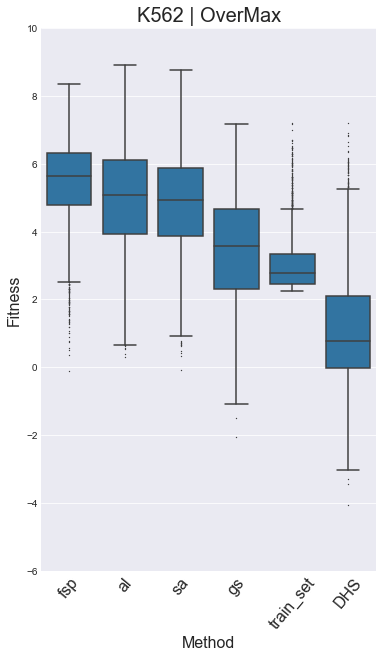

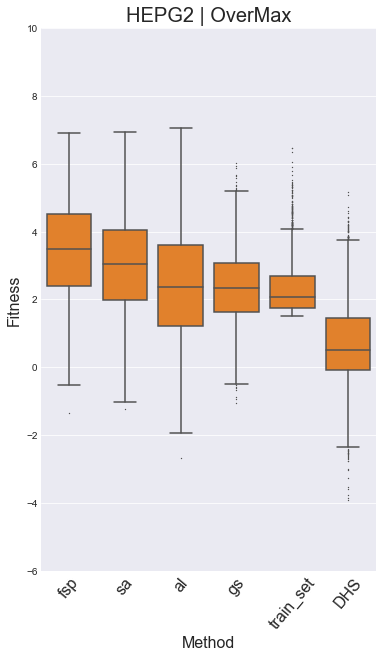

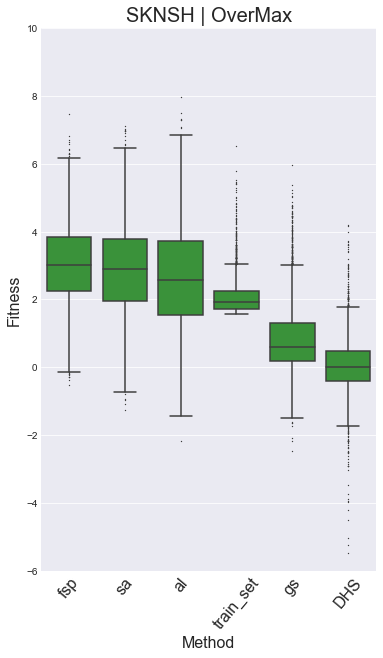

In [20]:
method_subset = ['DHS', 'train_set', 'gs', 'fsp', 'al', 'sa']
#method_subset = ['DHS', 'train_set', 'gs', 'fsp', 'al', 'sa', 'fsp_uc', 'al_uc', 'sa_uc']
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
plot_df = rounds_0_df[quality_filter].copy().reset_index(drop=True)
plot_df = plot_df[plot_df['method'].isin(method_subset)]

for color_idx, cell_type in enumerate(['k562', 'hepg2', 'sknsh']):  
    temp_df2 = plot_df[(plot_df['target_cell'] == cell_type)].copy()
    temp_order = temp_df2.groupby(by=['method'])['OverMax'].median().sort_values(ascending=False).index     
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(6,10))
        sns.boxplot(data=temp_df2, x='method', y='OverMax', order=temp_order, fliersize=0.5, color='C'+str(color_idx))
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('Fitness', fontsize=16)
        plt.title(f'{cell_type.upper()} | OverMax', fontsize=20)
        plt.ylim(-6, 10)
        plt.show()

In [60]:
rounds_0_df.columns

Index(['ID', 'sequence', 'project', 'method', 'round', 'K562_signal',
       'HepG2_signal', 'SKNSH_signal', 'K562_lfcSE', 'HepG2_lfcSE',
       'SKNSH_lfcSE', 'K562_ctrl_mean', 'HepG2_ctrl_mean', 'SKNSH_ctrl_mean',
       'K562_exp_mean', 'HepG2_exp_mean', 'SKNSH_exp_mean', 'K562_pred',
       'HepG2_pred', 'SKNSH_pred', 'K562_pred_aggreg', 'HepG2_pred_aggreg',
       'SKNSH_pred_aggreg', 'pred_max_cell', 'signal_max_cell', 'target_cell',
       'target_cell_lfc', 'max_non_target_cell', 'max_non_target_lfc',
       'min_non_target_cell', 'min_non_target_lfc', 'mean_non_target_lfc',
       'OverMean', 'OverMax', 'contrib_K562', 'contrib_HepG2',
       'contrib_SKNSH'],
      dtype='object')

In [62]:
target_dict = {'k562': 'K562_pred',
              'hepg2': 'HepG2_pred',
              'sknsh': 'SKNSH_pred'}

target_lfc_list = []
for i in tqdm(range(len(rounds_0_df))):
    temp_row = rounds_0_df.iloc[[i]]
    target_lfc_list.append(temp_row[target_dict[temp_row['target_cell'].item()]].item())
    
rounds_0_df['target_cell_pred'] = target_lfc_list

  0%|          | 0/96900 [00:00<?, ?it/s]

In [72]:
nontarget_dict = {'k562': ['HepG2_pred', 'SKNSH_pred'],
                 'hepg2': ['K562_pred', 'SKNSH_pred'],
                 'sknsh': ['K562_pred', 'HepG2_pred']}

nontarget_lfc_list = []
for i in tqdm(range(len(rounds_0_df))):
    temp_row = rounds_0_df.iloc[[i]]
    nontarget_lfc_list.append(temp_row[nontarget_dict[temp_row['target_cell'].item()]].max(axis=1).item())
    
rounds_0_df['max_non_target_pred'] = nontarget_lfc_list

  0%|          | 0/96900 [00:00<?, ?it/s]

In [73]:
rounds_0_df['OverMax_pred'] = rounds_0_df['target_cell_pred'] - rounds_0_df['max_non_target_pred']

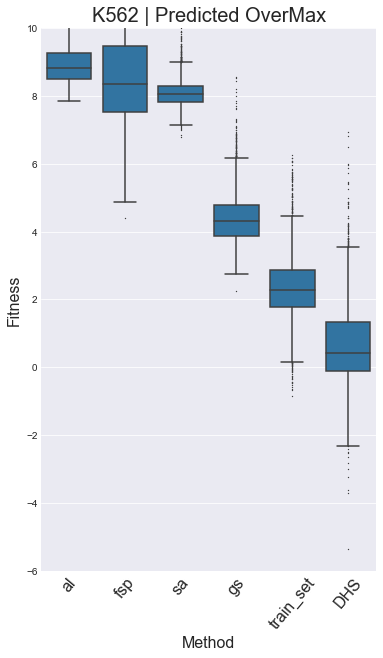

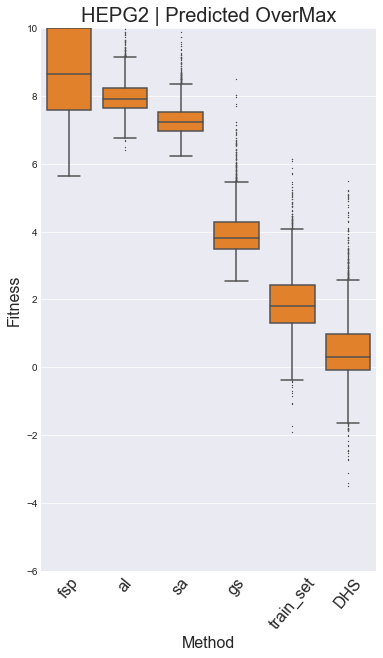

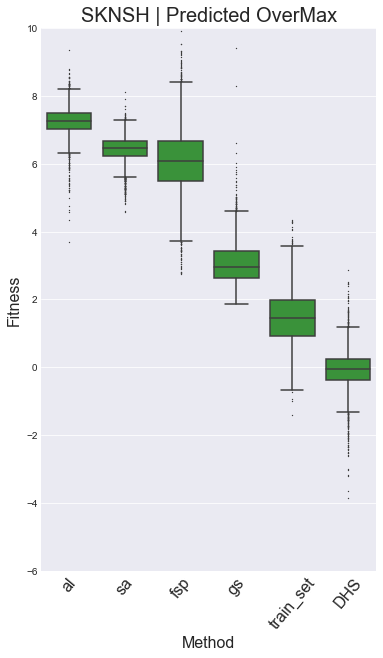

In [74]:
method_subset = ['DHS', 'train_set', 'gs', 'fsp', 'al', 'sa']
#method_subset = ['DHS', 'train_set', 'gs', 'fsp', 'al', 'sa', 'fsp_uc', 'al_uc', 'sa_uc']
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
plot_df = rounds_0_df[quality_filter].copy().reset_index(drop=True)
plot_df = plot_df[plot_df['method'].isin(method_subset)]

for color_idx, cell_type in enumerate(['k562', 'hepg2', 'sknsh']):  
    temp_df2 = plot_df[(plot_df['target_cell'] == cell_type)].copy()
    temp_order = temp_df2.groupby(by=['method'])['OverMax_pred'].median().sort_values(ascending=False).index     
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(6,10))
        sns.boxplot(data=temp_df2, x='method', y='OverMax_pred', order=temp_order, fliersize=0.5, color='C'+str(color_idx))
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('Fitness', fontsize=16)
        plt.title(f'{cell_type.upper()} | Predicted OverMax', fontsize=20)
        plt.ylim(-6, 10)
        plt.show()

In [21]:
train_set_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/MPRA_ALL_no_cutoffs_v2_pred.txt', sep=" ", low_memory=False)

In [22]:
boda2_set = set(boda2_df['sequence'])
train_set = set(train_set_df['nt_sequence'])

common_seqs = list(set.intersection(boda2_set, train_set))

In [24]:
shared_boda1 = train_set_df[train_set_df['nt_sequence'].isin(common_seqs)].sort_values('nt_sequence').reset_index(drop=True)
shared_boda2 = boda2_df[boda2_df['sequence'].isin(common_seqs)].sort_values('sequence').reset_index(drop=True)

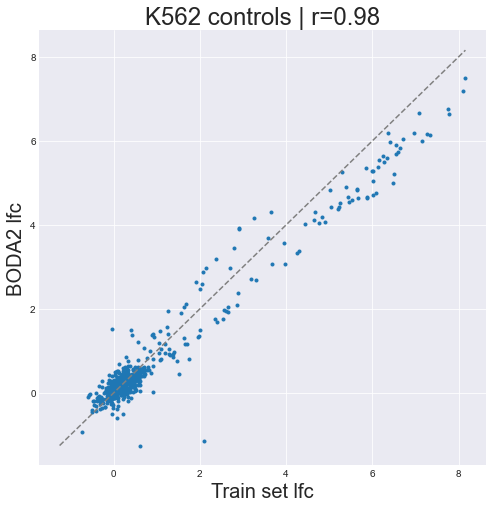

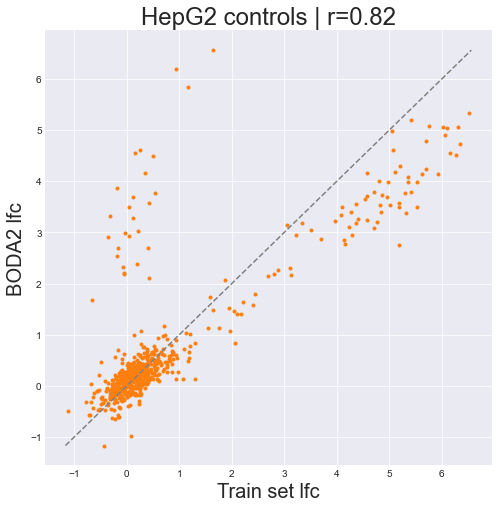

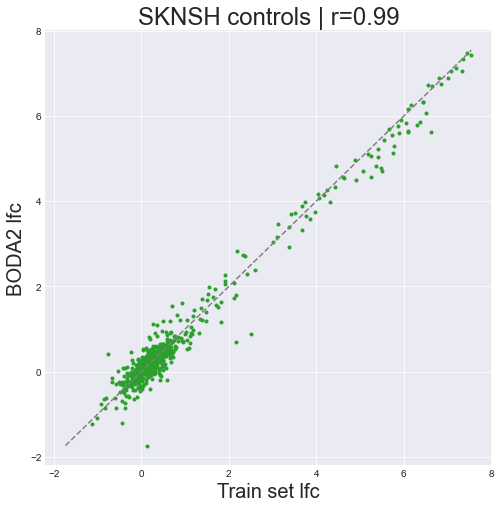

In [25]:
cell_types = ['K562', 'HepG2', 'SKNSH']
with plt.style.context('seaborn-darkgrid'): 
    for idx, cell_type in enumerate(cell_types):
        x = shared_boda1[f'{cell_type}_mean']
        y = shared_boda2[f'{cell_type}_signal']

        plt.figure(figsize=(8,8))
        plt.scatter(x, y, marker='.', color='C'+str(idx))
        
        MIN = min(x.min(), y.min())
        MAX = max(x.max(), y.max())
        plt.plot((MIN, MAX), (MIN, MAX), '--', color='gray')
        
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        corr = round(stats.pearsonr(x[~nas], y[~nas])[0], 2)

        plt.title(f'{cell_type} controls | r={corr}', fontsize=24)
        plt.xlabel('Train set lfc', fontsize=20)
        plt.ylabel('BODA2 lfc', fontsize=20)
        plt.show()

In [30]:
shared_boda1[['IDs', 'HepG2_mean']]

,IDs,HepG2_mean
0,10:35356774:A:G:R:wC,0.412191
1,18:59459930:C:T:R:wC,-0.393849
2,2:33568589:NA:NA,0.300419
3,1:76144459:C:T:R:wC,-0.309000
4,15:36891821:NA:NA,0.150122
...,...,...
599,1:239122623:GATAGA:G:R:wC,0.308601
600,2:39927430:NA:NA,0.012142
601,1:220849826:C:G:R:wC,0.262912
602,4:154379480:C:T:R:wC,-0.042372


In [32]:
shared_boda2[['ID', 'HepG2_signal']]

,ID,HepG2_signal
0,10:35356774:A:G:R:wC,2.700025
1,18:59459930:C:T:R:wC,-0.099401
2,2:33568589:NA:NA,0.102959
3,1:76144459:C:T:R:wC,-0.232973
4,15:36891821:NA:NA,0.303674
...,...,...
599,1:239122623:GATAGA:G:R:wC,0.410093
600,2:39927430:NA:NA,0.408172
601,1:220849826:C:G:R:wC,0.117906
602,4:154379480:C:T:R:wC,-0.077456


In [90]:
row_filter = ((shared_boda2['HepG2_signal'] - shared_boda1['HepG2_mean']) > 2.0)
sequences = shared_boda2[row_filter]['sequence'].tolist()
ids = shared_boda2[row_filter]['ID'].tolist()
for idx, sequence in enumerate(sequences):
    print(f'>{ids[idx]}')
    print(sequence)

>10:35356774:A:G:R:wC
AAAAAAAAAAAATTCACCATTATTGTTTATTCTATTTATATAAAGTCCAAGAAAATTCACCATTTAAGAACCACAAAAGGGCCGGACGTGGTGGCTCATACCTGTAATCCCAGCACTTTGGGAGGCTGAGGCAGGCGGATCACGAGGTCAGGAGATCGAGACCATCCTGGTTAACACGGTGAAACCCTGTCTCTACTAAA
>15:82258451:C:T:R:wC
AAAGCTATGACATTATAAGGAAATGATATATTAACTGGTAGAACTCAGGAAAGAAGTAAAACGGATAAATCATTATTAAAAAGGGTTATATTGCGGTGGCTCACACCTGTAATCCCAGCACTTTGGGAGGCCGAGGCAGGTGGATCATGAGGTCAGGAGATCAAGACCACCCTGGCTAACACAGTGAAGCCCCATCTGTA
>1:53246910:C:T:R:wC
AACAACAACAACAACAACCAAAGTTGTCCTTTAACCACTAGAAGTCTAGGATGTTGCTTATTTAAAAAGCTTATTTGTGGCCAGGCATGGTGGCTCACACCTGTAATCCCAGTACTTTGGGAAGCCAAGGCAGGCAGATCACTTGAGCTCAGGAGTTCAAGACCAGCCTGGGCAACATGGCAAAACCCCATCTCTACAAA
>20:61478285:G:C:R:wC
AAGAAAAAAGAAATAGCTCTAACTATGAGTCAGGAAAATATACCAGGAAGTTATTAAGAGGAAGAAAGCGGCCGGGTGCAGTGGCTCACACCTGTAATCGCAGCACTTTGGGAGGCCGAGGTGGGTGGATCACCTGAGGTCGGGAGTTCACGACCAGCCTCACCAACATGGAGAAACCCCATCTCTAATAAAAATACAAA
>9:130203840:G:C:R:wC
AAGAGGTGGAGCCCAGATTTGAACCCAGCCAGTCTGGTTGAAGACTGTGTATAGAAATTCAAGGAAACAGTTGGGCGTGGTGGCTCA

In [216]:
out_df

,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH
0,20211210_200256__612928__5::fsp_uc__hepg2__0,CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...,BODA:hepg2,fsp_uc,0,2.520816,5.287727,0.605723,0.316205,0.309186,0.208455,450.265971,450.265971,450.265971,2584.983789,17588.102886,684.911429,-0.055265,14.231705,0.080212,0.140002,14.336414,0.227027,hepg2,hepg2,hepg2,5.287727,k562,2.520816,sknsh,0.605723,1.563270,3.724457,2.766911,[ 2.21043210e-02 4.64022532e-03 1.00994157e-...,[ 1.1422859e-01 2.5873125e-01 2.2765625e-01 ...,[ 0.004331928 0.07783466 0.06386908 ...
1,20211210_200256__612928__12::fsp_uc__hepg2__0,GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...,BODA:hepg2,fsp_uc,0,0.609272,6.402153,0.271218,0.285060,0.301327,0.340279,186.544915,186.544915,186.544915,285.193149,15770.229152,224.886662,-0.019169,19.914394,0.777519,-0.011601,18.561650,0.767500,hepg2,hepg2,hepg2,6.402153,k562,0.609272,sknsh,0.271218,0.440245,5.961907,5.792880,[-0.00856874 -0.012687626 0.03335264 ...,[-2.79185679e-02 2.33078538e-03 2.57074833e-...,[-0.017693618 -0.015454747 0.01019545 ...
2,20211210_200256__612928__47::fsp_uc__hepg2__0,GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...,BODA:hepg2,fsp_uc,0,1.486130,4.276053,-0.578350,0.271874,0.366801,0.241865,914.631030,914.631030,914.631030,2563.392133,17720.211245,612.217031,-0.146010,12.227689,-0.400996,-0.034775,10.825762,-0.337030,hepg2,hepg2,hepg2,4.276053,k562,1.486130,sknsh,-0.578350,0.453890,3.822163,2.789924,[-5.54974526e-02 -2.83153541e-02 -1.36791170e-...,[ 0.041962117 0.2561933 0.058943637 0....,[-4.9518015e-02 -2.5722878e-02 -4.6560772e-02 ...
3,20211210_200256__612928__69::fsp_uc__hepg2__0,TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...,BODA:hepg2,fsp_uc,0,2.440630,5.615395,1.063669,0.219559,0.313984,0.230603,141.922642,141.922642,141.922642,771.612103,6958.102060,296.614753,1.216181,18.812680,1.589409,1.416824,17.606884,1.713512,hepg2,hepg2,hepg2,5.615395,k562,2.440630,sknsh,1.063669,1.752150,3.863246,3.174765,[ 0.16365409 0.0731409 0.114835456 ...,[ 1.40735984e-01 1.30295590e-01 1.24457464e-...,[ 1.11630686e-01 9.51312631e-02 1.00722231e-...
4,20211210_200256__612928__93::fsp_uc__hepg2__0,AACACGGGCACGGGGGGGCGCTGTTTGAGTTTAAAAACGATCTAGG...,BODA:hepg2,fsp_uc,0,3.765216,4.683140,0.171043,0.570148,0.612207,2.165178,6.626839,6.626839,6.626839,90.495400,169.731161,7.443428,1.832291,18.612158,1.411221,2.409507,17.280722,2.059474,hepg2,hepg2,hepg2,4.683140,k562,3.765216,sknsh,0.171043,1.968129,2.715011,0.917925,[ 0.017253371 0.03226251 -0.008712402 ...,[ 0.04122336 0.040660232 -0.0046606357 ...,[ 0.05285579 0.042130962 -0.035606854 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1:59616735:A:G:R:wC,GCTAAATGCATATGTGAATGCATGATGCATAAGTGACTGTGATTGC...,GTEX:GTEx,train_set,0,0.675106,0.837604,2.420064,0.152218,0.119655,0.174285,876.490212,882.880295,882.880295,1399.286423,1579.623392,4721.633087,0.732202,0.817832,1.554083,0.737586,1.024049,1.820509,NaN,NaN,sknsh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.582460,NaN,NaN,NaN
3996,22:45729382:C:T:R:wC:Alt_22-45729424-A,CGATAGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCTGAGGTGG...,"UKBB:Balding_Type4,eBMD",train_set,0,1.546432,-0.401011,3.128631,0.156739,0.262118,0.737954,456.615013,456.615013,456.615013,1138.134984,317.568222,4338.806686,1.656881,0.083859,1.806056,1.475326,0.007973,1.674513,NaN,NaN,sknsh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.582199,NaN,NaN,NaN
3997,3:183530978:G:A:A:wC:Alt_3-183530986-A,TCAAAGGCATTATGATACAGTCCAAGTATGTAAC

In [236]:
print((k562_specific_df['data_project'] == 'UKBB').sum())
print((k562_specific_df['data_project'] == 'GTEX').sum())
print((k562_specific_df['data_project'] == 'BODA30K').sum())

2074
1698
228


In [237]:
print((hepg2_specific_df['data_project'] == 'UKBB').sum())
print((hepg2_specific_df['data_project'] == 'GTEX').sum())
print((hepg2_specific_df['data_project'] == 'BODA30K').sum())

1567
2295
138


In [238]:
print((sknsh_specific_df['data_project'] == 'UKBB').sum())
print((sknsh_specific_df['data_project'] == 'GTEX').sum())
print((sknsh_specific_df['data_project'] == 'BODA30K').sum())

1471
2471
58


In [248]:
out_df.to_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v2.txt', sep=" ", index=None)

In [88]:
sequences = hepg2_specific_df[hepg2_specific_df['target_cell'] == 'hepg2'].sort_values(by='OverMax')['sequence'][-100:].tolist()
for idx, sequence in enumerate(sequences):
    print(f'>sequence_{idx}')
    print(sequence)

>sequence_0
TCCCTGGGATGAGTGAGGCAAGAAGGAGAATATGAGCTGTGGACTACGAGAAAAAAAACCAGAGTGACTGAAGGAGAAGGAACTCCTGGTCCTTCCTGGTGACCCAGAGCCAACAGAGAAATGGGTAACTCATTAACCAGAGAACAGTCCCACATCCTGTGTGTGAAAGAAAGAAACATTTTAAAAGTTAGAAAATGCAT
>sequence_1
GAGGTCTGTTCTTTGTGATGGGAAGAATGAAAAAAAAAAGAGGTATGAACCTTATTCAAGTTTAAGAAACGTATGAAAAGAAAGAAATCCAAAGTTCCTGTCTCACCTGGGTTAATAAGTAACAGTGTGACCTTGGGCAAGTTGCTTAGCCCTTTAAACATAATTTTCATCTTTGTAAAATGAGAAGATTGATATATGAT
>sequence_2
TGTTTTCCTGTTTCAACGGTGGATGCCAATCTGTGTGTTTATTCAACCACACACTTTCTTTCTGCCATTATTCCATGTTCTAGGGGACAATTTTGAGTCATAATAGCTGGTAAAAGGCAAACAAATCAAAGTTCAGGAGGTGTAGCAAACATGCCACAAGAGTATTGCACAAGGCAACTAGGAACAGCAGGTCATGCCTG
>sequence_3
GCCCCGTGCCCTGTGTAGAGTGGGCCCCGGGGCATGTTTGCTCAGTGACTGAATGAAATGGGAATGACCTCATTTATTTGTTTTGGGTCAGGAGTAGTTATGAAAAGGTGGGATGAAGGGGGAATCGCTGAGGTTGGGAGGAAAAATAGAAGCCCTCTCAAAACCATCTGGTGTGCCTGCGGTGGCGTGGCGCGGCTCAG
>sequence_4
CTTCCTCCCTGGGATGAGTGAGGCAAGAAGGAGAATATGAGCTGTGGACTACGAGAAAAAAAACCAGAGTGACTGAAGGAGAAGGAACTCCTGGTCCTTCCTGGTGACCCAGAGCCAACAGAGAAATGGGTAACTC

In [87]:
hepg2_specific_df[hepg2_specific_df['target_cell'] == 'hepg2'].sort_values(by='OverMax')['OverMax'][-100:]

99    4.538482
98    4.540184
97    4.547738
96    4.547943
95    4.548123
        ...   
4     6.332406
3     6.430811
2     6.451162
1     6.460408
0     7.269002
Name: OverMax, Length: 100, dtype: float64

In [1]:
boda2_df

NameError: name 'boda2_df' is not defined